In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
from torch.optim.lr_scheduler import StepLR
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier


In [ ]:
datapath = '/content/drive/MyDrive/Pattern Assignment/RTA Dataset.csv'
df = pd.read_csv(datapath)

df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [ ]:
print(df.columns)

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')


In [ ]:
# Prepare data for Random Forest
X = df.drop(columns=["Accident_severity"])  # Features
y = df["Accident_severity"]  # Target variable

X['Time'] = pd.to_datetime(X['Time']).dt.hour  # Extract hour as a numerical feature

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importances[["Number_of_casualties", "Casualty_class", "Sex_of_casualty",
                     "Age_band_of_casualty", "Casualty_severity", "Work_of_casuality",
                     "Fitness_of_casuality"]]

<ipython-input-6-c19c1ae4d84d>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['Time'] = pd.to_datetime(X['Time']).dt.hour  # Extract hour as a numerical feature


,0
Number_of_casualties,0.032627
Casualty_class,0.022301
Sex_of_casualty,0.019087
Age_band_of_casualty,0.030239
Casualty_severity,0.014659
Work_of_casuality,0.032462
Fitness_of_casuality,0.013913


In [ ]:
df = df.drop(columns=['Number_of_casualties', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality'])

In [ ]:
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved', 'Vehicle_movement',
       'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [ ]:
unique_counts = df.nunique()
print(unique_counts)

Time                           1074
Day_of_week                       7
Age_band_of_driver                5
Sex_of_driver                     3
Educational_level                 7
Vehicle_driver_relation           4
Driving_experience                7
Type_of_vehicle                  17
Owner_of_vehicle                  4
Service_year_of_vehicle           6
Defect_of_vehicle                 3
Area_accident_occured            14
Lanes_or_Medians                  7
Road_allignment                   9
Types_of_Junction                 8
Road_surface_type                 5
Road_surface_conditions           4
Light_conditions                  4
Weather_conditions                9
Type_of_collision                10
Number_of_vehicles_involved       6
Vehicle_movement                 13
Pedestrian_movement               9
Cause_of_accident                20
Accident_severity                 3
dtype: int64


In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Vehicle_movement', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']


In [ ]:
print(df.isnull().sum())

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Vehicle_movement                308
Pedestrian_movement               0
Cause_of_accident                 0
Accident_severity                 0
dtype: int64


In [ ]:
def predictive_imputation(df):
    df_imputed = df.copy()

    cols_with_nan = df_imputed.columns[df_imputed.isnull().any()]

    for target in cols_with_nan:
        print(f"Imputing column: {target}")

        train_data = df_imputed[df_imputed[target].notnull()].copy()
        test_data  = df_imputed[df_imputed[target].isnull()].copy()

        if train_data.empty or test_data.empty:
            continue

        predictors = [col for col in df_imputed.columns if col != target]


        for col in predictors:
            if train_data[col].isnull().any():
                if train_data[col].dtype == 'object' or train_data[col].dtype.name == 'category':
                    imp = SimpleImputer(strategy='most_frequent')
                else:
                    imp = SimpleImputer(strategy='median')
                train_data[col] = imp.fit_transform(train_data[[col]]).ravel() # ravel to flatten array
                test_data[col] = imp.transform(test_data[[col]]).ravel() # ravel to flatten array


        is_categorical = (train_data[target].dtype == 'object' or
                          train_data[target].dtype.name == 'category')


        X_train = train_data[predictors].copy()
        X_test  = test_data[predictors].copy()
        for col in X_train.columns:
            if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
              if col == 'Time':
                X_train[col] = pd.to_datetime(X_train[col]).dt.hour
                X_test[col] = pd.to_datetime(X_test[col]).dt.hour
              else:

                le = LabelEncoder()
                # Fit on training data and transform both training and test sets
                X_train[col] = le.fit_transform(X_train[col].astype(str))
                try:
                  X_test[col] = le.transform(X_test[col].astype(str))
                except ValueError as e:
                  unseen_labels = set(X_test[col].astype(str)) - set(le.classes_)
                  for label in unseen_labels:
                    le.classes_ = np.append(le.classes_, label)
                  X_test[col] = le.transform(X_test[col].astype(str))




        # Predict missing values using a suitable model:
        if is_categorical:
            # Encode the target column
            le_target = LabelEncoder()
            y_train = le_target.fit_transform(train_data[target].astype(str))
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # Reverse the label encoding for predictions
            predicted = le_target.inverse_transform(y_pred)
        else:
            y_train = train_data[target]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            predicted = model.predict(X_test)

        # Fill the missing values in the original DataFrame
        df_imputed.loc[df_imputed[target].isnull(), target] = predicted

    return df_imputed

df_imputed = predictive_imputation(df)
print(df_imputed.isnull().sum())


Imputing column: Educational_level


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Vehicle_driver_relation


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Driving_experience


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Type_of_vehicle


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Owner_of_vehicle


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Service_year_of_vehicle


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Defect_of_vehicle


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Area_accident_occured


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Lanes_or_Medians


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Road_allignment


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Types_of_Junction


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Road_surface_type


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Type_of_collision


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Imputing column: Vehicle_movement


<ipython-input-12-c8aa574b9bb1>:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train[col] = pd.to_datetime(X_train[col]).dt.hour
<ipython-input-12-c8aa574b9bb1>:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test[col] = pd.to_datetime(X_test[col]).dt.hour


Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Service_year_of_vehicle        0
Defect_of_vehicle              0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Vehicle_movement               0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
dtype: int64


In [ ]:
df_imputed.to_csv('/content/drive/MyDrive/Pattern Assignment/RTA Dataset_Cleaned.csv',index = False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
path2 = '/content/drive/MyDrive/Pattern Assignment/RTA Dataset_Cleaned.csv'
df2 = pd.read_csv(path2)
print(df2.isnull().sum())

Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Service_year_of_vehicle        0
Defect_of_vehicle              0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Vehicle_movement               0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
dtype: int64


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            12316 non-null  object
 5   Vehicle_driver_relation      12316 non-null  object
 6   Driving_experience           12316 non-null  object
 7   Type_of_vehicle              12316 non-null  object
 8   Owner_of_vehicle             12316 non-null  object
 9   Service_year_of_vehicle      12316 non-null  object
 10  Defect_of_vehicle            12316 non-null  object
 11  Area_accident_occured        12316 non-null  object
 12  Lanes_or_Medians             12316 non-null  object
 13  Road_allignment              12

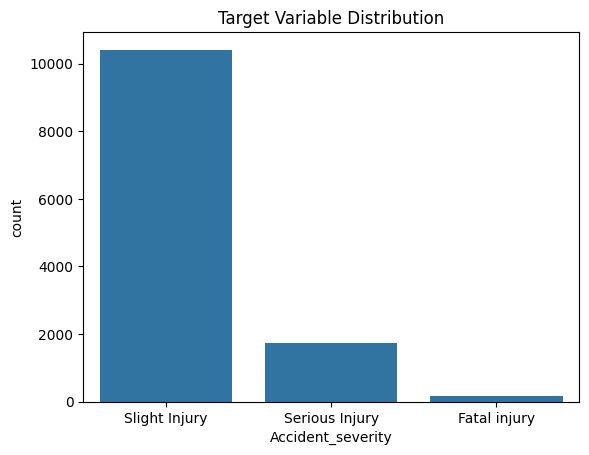

In [ ]:
sns.countplot(x='Accident_severity', data=df2)
plt.title('Target Variable Distribution')
plt.show()

In [ ]:
df2['Time'] = pd.to_datetime(df2['Time'], format='%H:%M:%S')

In [ ]:
df2['hour'] = df2['Time'].dt.hour
df2['minute'] = df2['Time'].dt.minute
df2['second'] = df2['Time'].dt.second

In [ ]:
df2 = df2.drop(columns=['Time'])

In [ ]:
df2['total_seconds'] = df2['hour'] * 3600 + df2['minute'] * 60 + df2['second']

In [ ]:
# Apply LabelEncoder to each categorical column separately
label_encoders = {}  # Dictionary to store encoders if needed for inverse transformation later

categorical_cols = ['Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation',
                    'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
                    'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
                    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions',
                    'Weather_conditions', 'Type_of_collision', 'Vehicle_movement', 'Pedestrian_movement',
                    'Cause_of_accident', 'Accident_severity']

for col in categorical_cols:
    le = LabelEncoder()
    df2[col] = le.fit_transform(df[col])  # Encode the column
    label_encoders[col] = le  # Store the encoder if needed for decoding later


In [ ]:
categorical_columns = df2.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: []


In [ ]:
print(df2['Accident_severity'].value_counts())

Accident_severity
2    10415
1     1743
0      158
Name: count, dtype: int64


In [ ]:
X = df2.drop(columns=['Accident_severity'])
y = df2['Accident_severity']
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

adasyn = ADASYN(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
print(pd.Series(y_resampled).value_counts())

Accident_severity
0    8353
2    8331
1    8324
Name: count, dtype: int64


<ipython-input-37-a1e617e40b1d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_counts.index, y=y_train_counts.values, ax=axes[0], palette="coolwarm")
<ipython-input-37-a1e617e40b1d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_resampled_counts.index, y=y_resampled_counts.values, ax=axes[1], palette="coolwarm")


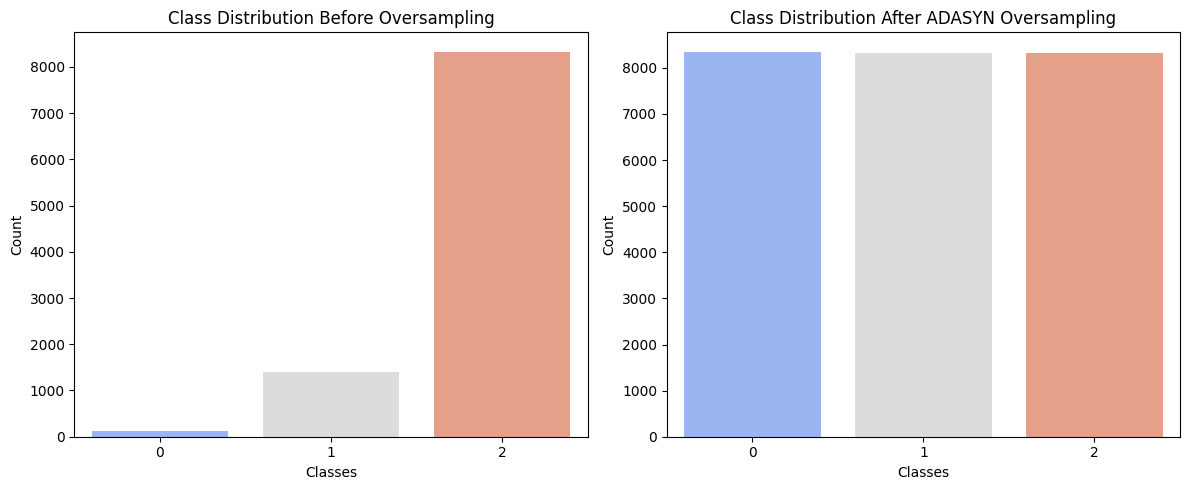

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
y_train_counts = pd.Series(y_train).value_counts()
y_resampled_counts = pd.Series(y_resampled).value_counts()
# Before Oversampling
sns.barplot(x=y_train_counts.index, y=y_train_counts.values, ax=axes[0], palette="coolwarm")
axes[0].set_title("Class Distribution Before Oversampling")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Count")

# After Oversampling
sns.barplot(x=y_resampled_counts.index, y=y_resampled_counts.values, ax=axes[1], palette="coolwarm")
axes[1].set_title("Class Distribution After ADASYN Oversampling")
axes[1].set_xlabel("Classes")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

**Random Forest**

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]   # Minimum number of samples required to be at a leaf node
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)
print(f"Best Parameters: {grid_search.best_params_}")

# Step 5: Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_resampled, y_resampled)

# Step 6: Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nPrecision:")
print(precision_score(y_test,y_pred,average='weighted'))
print("\nRecall:")
print(recall_score(y_test,y_pred,average='weighted'))
print("\nF1 Score:")
print(f1_score(y_test,y_pred,average='weighted'))
print(classification_report(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 82.59%

Precision:
0.7858285832573515

Recall:
0.8258928571428571

F1 Score:
0.7976577989970709
              precision    recall  f1-score   support

           0       0.50      0.03      0.06        31
           1       0.35      0.18      0.24       349
           2       0.86      0.95      0.90      2084

    accuracy                           0.83      2464
   macro avg       0.57      0.39      0.40      2464
weighted avg       0.79      0.83      0.80      2464


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.03      0.06        31
           1       0.35      0.18      0.24       349
           2       0.86      0.95      0.90      2084

    accuracy                           0.83      2464
   macro avg       0.57      0.39      0.40      2464
weighted avg       0.79      0.83      0.80      2464


Co

**CatBoost**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_feature_indices = []
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    cat_feature_indices.append(X_train.columns.get_loc(col))

# Apply ADASYN to the training set to handle severe class imbalance
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# Define a hyperparameter grid for CatBoostClassifier
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostClassifier with the categorical feature indices.
# verbose=0 is set to suppress the detailed training logs during grid search.
catboost_model = CatBoostClassifier(
    cat_features=cat_feature_indices,
    random_seed=42,
    verbose=0
)

# Set up GridSearchCV using 3-fold cross-validation
grid_search = GridSearchCV(catboost_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best estimator from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%\n")

print("Precision:")
print(precision_score(y_test, y_pred, average='weighted'))
print("Recall:")
print(recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:")
print(f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best parameters found: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9135413209425822
Test Set Accuracy: 84.46%

Precision:
0.7981844147504342
Recall:
0.8445616883116883
F1 Score:
0.7913718343178028
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.06      0.09        31
           1       0.52      0.06      0.11       349
           2       0.85      0.99      0.92      2084

    accuracy                           0.84      2464
   macro avg       0.51      0.37      0.37      2464
weighted avg       0.80      0.84      0.79      2464

Confusion Matrix:
[[   2    1   28]
 [   2   22  325]
 [   8   19 2057]]


**CNN_LSTM**

In [ ]:
X = df2.drop(columns=['Accident_severity'])
y = df2['Accident_severity']

categorical_columns = X.columns.tolist()
vocab_sizes = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    vocab_sizes[col] = X[col].nunique()

le_target = LabelEncoder()
y = le_target.fit_transform(y)
num_classes = len(np.unique(y))

X = X.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

adasyn = ADASYN(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# Since SMOTE produces continuous values, round them to the nearest integer.
X_train_res = np.rint(X_train_res).astype(int)

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_res, y_train_res)
test_dataset = TabularDataset(X_test, y_test)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 6. Define the CNN-BiLSTM Model
class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_sizes, embedding_dim, num_filters, kernel_size, lstm_hidden, num_classes):
        super(CNN_BiLSTM, self).__init__()
        # Embedding layers for categorical features
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=vocab_sizes[col] + 1, embedding_dim=embedding_dim)
            for col in vocab_sizes
        ])

        # CNN Layer
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global max pooling

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=lstm_hidden,
                            num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(lstm_hidden * 2, 64)  # BiLSTM is bidirectional
        self.dropout = nn.Dropout(0.5)
        self.layer_norm = nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x[:, i]))  # (batch, embedding_dim)

        # Stack embeddings: (batch, num_features, embedding_dim)
        x_emb = torch.stack(embeddings, dim=1)

        # --- CNN Branch ---
        x_cnn = x_emb.transpose(1, 2)
        x_conv = self.conv1d(x_cnn)
        x_pool = self.pool(x_conv)
        x_pool = x_pool.squeeze(2)

        # --- BiLSTM Branch ---
        x_lstm_input = x_pool.unsqueeze(1)
        lstm_out, _ = self.lstm(x_lstm_input)
        lstm_out = lstm_out.squeeze(1)

        # Fully Connected Layer
        x_fc = self.fc1(lstm_out)
        x_fc = torch.relu(x_fc)
        x_fc = self.dropout(x_fc)
        logits = self.fc2(x_fc)

        return logits
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# set_seed(42)
embedding_dim = 30
num_filters = 64
kernel_size = 3
lstm_hidden = 128
num_epochs = 20
learning_rate = 0.001

model = CNN_BiLSTM(vocab_sizes=vocab_sizes,
                    embedding_dim=embedding_dim,
                    num_filters=num_filters,
                    kernel_size=kernel_size,
                    lstm_hidden=lstm_hidden,
                    num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 8. Training the Model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# 9. Evaluate the model on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calculate accuracy
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Precision:")
print(precision_score(all_labels, all_preds, average='weighted'))
print("Recall:")
print(recall_score(all_labels, all_preds, average='weighted'))
print("F1 score:")
print(f1_score(all_labels, all_preds, average='weighted'))

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Epoch 1/20, Loss: 0.7808
Epoch 2/20, Loss: 0.5411
Epoch 3/20, Loss: 0.4162
Epoch 4/20, Loss: 0.3593
Epoch 5/20, Loss: 0.3252
Epoch 6/20, Loss: 0.2878
Epoch 7/20, Loss: 0.2767
Epoch 8/20, Loss: 0.2602
Epoch 9/20, Loss: 0.2382
Epoch 10/20, Loss: 0.2369
Epoch 11/20, Loss: 0.1944
Epoch 12/20, Loss: 0.1885
Epoch 13/20, Loss: 0.1833
Epoch 14/20, Loss: 0.1742
Epoch 15/20, Loss: 0.1753
Epoch 16/20, Loss: 0.1651
Epoch 17/20, Loss: 0.1661
Epoch 18/20, Loss: 0.1664
Epoch 19/20, Loss: 0.1528
Epoch 20/20, Loss: 0.1545
Test Accuracy: 82.22%
Precision:
0.773341047229876
Recall:
0.8222402597402597
F1 score:
0.7900372350367105
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.10      0.11        31
           1       0.32      0.13      0.18       349
           2       0.86      0.95      0.90      2084

    accuracy                           0.82      2464
   macro avg       0.44      0.39      0.40      2464
weighted avg       0.77      0.82

**CNN**

In [ ]:
categorical_columns = X.columns.tolist()
vocab_sizes = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    vocab_sizes[col] = X[col].nunique()

le_target = LabelEncoder()
y = le_target.fit_transform(y)
num_classes = len(np.unique(y))

X = X.values

=X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

adasyn = ADASYN(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

X_train_res = np.rint(X_train_res).astype(int)

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_res, y_train_res)
test_dataset  = TabularDataset(X_test, y_test)

batch_size = 80
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class TabularCNN2D(nn.Module):
    def __init__(self, vocab_sizes, embedding_dim, num_filters, kernel_size, num_classes):
        super(TabularCNN2D, self).__init__()

        # Embedding layers for categorical features
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=vocab_sizes[col] + 1, embedding_dim=embedding_dim)
            for col in vocab_sizes
        ])

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(kernel_size, kernel_size), padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=(kernel_size, kernel_size), padding=1)

        # Pooling Layer
        self.pool = nn.AdaptiveMaxPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(num_filters * 2, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convert categorical inputs to embeddings
        embeddings = [emb_layer(x[:, i]) for i, emb_layer in enumerate(self.embeddings)]

        x_emb = torch.stack(embeddings, dim=1)  # (batch, num_features, embedding_dim)

        x_emb = x_emb.unsqueeze(1)

        # Apply CNN layers
        x_conv = torch.relu(self.conv1(x_emb))
        x_conv = torch.relu(self.conv2(x_conv))

        # Pooling
        x_pool = self.pool(x_conv)  # (batch, num_filters*2, 1, 1)
        x_pool = x_pool.view(x_pool.size(0), -1)  # Flatten

        # Fully Connected Layers
        x_fc = torch.relu(self.fc1(x_pool))
        x_fc = self.dropout(x_fc)
        logits = self.fc2(x_fc)

        return logits

embedding_dim = 30
num_filters = 64
kernel_size = 2
num_epochs = 20
learning_rate = 0.001

model = TabularCNN2D(vocab_sizes, embedding_dim, num_filters, kernel_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calculate Accuracy
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print Classification Report and Confusion Matrix
print("Precision:")
print(precision_score(all_labels, all_preds, average = 'weighted'))
print("Recall:")
print(recall_score(all_labels, all_preds, average = 'weighted'))
print("F1 Score:")
print(f1_score(all_labels, all_preds, average = 'weighted'))
print("Classification Report:")
print(classification_report(all_labels, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Epoch 1/20, Loss: 0.9648
Epoch 2/20, Loss: 0.7179
Epoch 3/20, Loss: 0.6146
Epoch 4/20, Loss: 0.5358
Epoch 5/20, Loss: 0.4789
Epoch 6/20, Loss: 0.4228
Epoch 7/20, Loss: 0.4011
Epoch 8/20, Loss: 0.3873
Epoch 9/20, Loss: 0.3689
Epoch 10/20, Loss: 0.3571
Epoch 11/20, Loss: 0.3394
Epoch 12/20, Loss: 0.3290
Epoch 13/20, Loss: 0.3239
Epoch 14/20, Loss: 0.3175
Epoch 15/20, Loss: 0.3078
Epoch 16/20, Loss: 0.3005
Epoch 17/20, Loss: 0.2953
Epoch 18/20, Loss: 0.2939
Epoch 19/20, Loss: 0.2898
Epoch 20/20, Loss: 0.2883
Test Accuracy: 80.97%
Precision:
0.7749912899879389
Recall:
0.8096590909090909
F1 Score:
0.7886429406382468
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.16      0.16        31
           1       0.31      0.17      0.22       349
           2       0.86      0.93      0.89      2084

    accuracy                           0.81      2464
   macro avg       0.44      0.42      0.42      2464
weighted avg       0.77      0.8

In [ ]:
print(pd.Series(y_resampled).value_counts())
print(pd.Series(y_test).value_counts())


1    8570
2    8331
0    8320
Name: count, dtype: int64
2    2084
1     349
0      31
Name: count, dtype: int64
